# ML Project: Predicting Movie Revenue
## Jupyter Notebook created by Emene Abah & Edouard de Schietere de Lophem

During the course of Machine Learning at ECAM we discovered to create our own machine learning model through exercices on Kaggle. This project is an extention of that, by giving us the task of developing our own model that can predict the revenue of a movie given it's attributes we received in a dataset.
To make this work, we first had to some data manipulation and processing to have a clear data set that is correct and usable for our final objective. Once this data was usable, we created multiple models so that we could analyze their performance and choose the best one (through cross validation) for our final model.


Install commands for the different libraries and tools we used:

In [371]:
%pip install scikit-learn
%pip install xgboost
%pip install numpy --upgrade

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.4 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 32] Le processus ne peut pas accéder au fichier car ce fichier est utilisé par un autre processus: 'c:\\users\\edoua\\anaconda3\\lib\\site-packages\\numpy\\typing\\__pycache__\\_dtype_like.cpython-39.pyc'
Consider using the `--user` option or check the permissions.



## Imports 

In [372]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import json

## Read Data

In [373]:
data_file_path = 'Dataset.csv'
data_read = pd.read_csv(data_file_path)
data_read.head()

,Unnamed: 0,vote_count,vote_average,title,tagline,status,spoken_languages,duration,revenue,release,...,production,popularity,overview,original_title,original_language,keywords,id,homepage,genres,financial_investment
0,0,11800,7.2,Avatar,Enter the World of Pandora.,Released,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",162.0,2.787965e+09,2009-12-10,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",150.437577,"In the 22nd century, a paraplegic Marine is di...",Avatar,en,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",19995,http://www.avatarmovie.com/,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",237000000.0
1,1,4500,6.9,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.",Released,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",169.0,9.610000e+08,2007-05-19,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",139.082615,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,en,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",285,http://disney.go.com/disneypictures/pirates/,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",300000000.0
2,2,4466,6.3,Spectre,A Plan No One Escapes,Released,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",148.0,8.806746e+08,2015-10-26,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",107.376788,A cryptic message from Bond’s past sends him o...,Spectre,en,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",206647,http://www.sonypictures.com/movies/spectre/,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",245000000.0
3,3,9106,7.6,The Dark Knight Rises,The Legend Ends,Released,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",165.0,1.084939e+09,2012-07-16,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",112.312950,Following the death of District Attorney Harve...,The Dark Knight Rises,en,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",49026,http://www.thedarkknightrises.com/,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",250000000.0
4,4,2124,6.1,John Carter,"Lost in our world, found in another.",Released,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",132.0,2.841391e+08,2012-03-07,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",43.926995,"John Carter is a war-weary, former military ca...",John Carter,en,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",49529,http://movies.disney.com/john-carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",260000000.0


## Treating Missing Data
Before we start building our model it is important to implement a way to treat missing values in our Dataset

In [374]:
data_read.isna().sum()

Unnamed: 0                    0
vote_count                    0
vote_average                480
title                         0
tagline                     844
status                        0
spoken_languages              0
duration                      2
revenue                      48
release                       1
countries_of_production       0
production                    0
popularity                    0
overview                      3
original_title                0
original_language           240
keywords                      0
id                            0
homepage                   3091
genres                        0
financial_investment        384
dtype: int64

From the result of the cell above we can see multiple columns have missing Data: 

**vote_average, tagline, duration, revenue, release, overview, original_language, homepage and financial_investment**

Some of those columns we will not fill in the missing values because we will drop the columns.
The data that we want to fill in our case is:

**vote_average, duration, revenue, release, original_language, financial_investment**

### Filling Release Date
We have one movie with a missing release date called **America is still the place**.

A google search tells us it was release 2022-06-10

In [375]:
# There is one missing release date. We looked it up and it is 2022-06-10 so we filled it in
movie_title = data_read[data_read['release'].isna()]['title'].values[0]
print(movie_title)

data_read['release'] = data_read['release'].fillna('2022-06-10')

data_read['release'] = pd.to_datetime(data_read['release'])

data_read['release'].head()

America Is Still the Place


0   2009-12-10
1   2007-05-19
2   2015-10-26
3   2012-07-16
4   2012-03-07
Name: release, dtype: datetime64[ns]

### Filling Original Languages
Some of the movies were missing their original languages. To make up for that the proccess we want to use is to fill it with the first language present in the **spoken_languages** columns

In [376]:

# Loading data into json format
data_read['spoken_languages'] = data_read['spoken_languages'].apply(json.loads)



While going over the data we have found that some movies have an empty list for spoken languages. We shall deal with it at the same time as the original language

In [377]:
empty_spoken_languages = data_read[data_read['spoken_languages'].apply(lambda x: len(x) == 0)]
empty_spoken_languages.head()

,Unnamed: 0,vote_count,vote_average,title,tagline,status,spoken_languages,duration,revenue,release,...,production,popularity,overview,original_title,original_language,keywords,id,homepage,genres,financial_investment
492,492,9,5.3,Top Cat Begins,NaN,Released,[],89.0,0.0,2015-10-30,...,"[{""name"": ""Anima Estudios"", ""id"": 9965}, {""nam...",0.719996,Top Cat has arrived to charm his way into your...,Don Gato: El inicio de la pandilla,es,"[{""id"": 209714, ""name"": ""3d""}]",293644,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 16, ""nam...",NaN
1169,1169,787,6.8,42,The True Story Of An American Legend,Released,[],128.0,95020213.0,2013-04-12,...,"[{""name"": ""Warner Bros."", ""id"": 6194}]",31.884559,"The powerful story of Jackie Robinson, the leg...",42,en,"[{""id"": 1480, ""name"": ""baseball""}, {""id"": 5565...",109410,NaN,"[{""id"": 18, ""name"": ""Drama""}]",40000000.0
2590,2590,25,5.9,VeggieTales: The Pirates Who Don't Do Anything,NaN,Released,[],85.0,0.0,2008-01-11,...,"[{""name"": ""Starz Animation"", ""id"": 2885}, {""na...",1.800119,Set Sail For Adventure! A boatload of beloved ...,VeggieTales: The Pirates Who Don't Do Anything,en,"[{""id"": 380, ""name"": ""brother brother relation...",15511,NaN,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 16, ""...",0.0
2614,2614,3,4.7,The Love Letter,A letter from the past would change their futu...,Released,[],98.0,0.0,1998-02-01,...,[],0.116873,20th century computer games designer Scott exc...,The Love Letter,en,[],57943,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",0.0
2631,2631,12,7.0,The Company,NaN,Released,[],276.0,0.0,2007-08-05,...,[],1.485324,Real-life figures from the Cold War era mix wi...,The Company,en,"[{""id"": 11162, ""name"": ""miniseries""}]",112430,NaN,"[{""id"": 18, ""name"": ""Drama""}]",0.0


In [378]:
# Filling the missing values in the original_language column with the first spoken language if there is one
def get_spoken_language_of_NaN(x):
    if pd.isna(x['original_language']):
        if x['spoken_languages'].__len__() == 0:
            # If there is no spoken language, we will assume it is English
            x['original_language'] = "en"
            x['spoken_languages'] = [{'iso_639_1': 'en'}]
        else:
            x['original_language'] = x['spoken_languages'][0]['iso_639_1']
    return x
data_read = data_read.apply(get_spoken_language_of_NaN, axis=1)
data_read['original_language'].isna().sum()

0

In [379]:
# Replaced spoken_languages with the number of languages spoken
data_read['spoken_languages'] = data_read['spoken_languages'].apply(lambda x: len(x))
#Some still have missing spoken languages
data_read[data_read['spoken_languages'] == 0].head()


,Unnamed: 0,vote_count,vote_average,title,tagline,status,spoken_languages,duration,revenue,release,...,production,popularity,overview,original_title,original_language,keywords,id,homepage,genres,financial_investment
492,492,9,5.3,Top Cat Begins,NaN,Released,0,89.0,0.0,2015-10-30,...,"[{""name"": ""Anima Estudios"", ""id"": 9965}, {""nam...",0.719996,Top Cat has arrived to charm his way into your...,Don Gato: El inicio de la pandilla,es,"[{""id"": 209714, ""name"": ""3d""}]",293644,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 16, ""nam...",NaN
1169,1169,787,6.8,42,The True Story Of An American Legend,Released,0,128.0,95020213.0,2013-04-12,...,"[{""name"": ""Warner Bros."", ""id"": 6194}]",31.884559,"The powerful story of Jackie Robinson, the leg...",42,en,"[{""id"": 1480, ""name"": ""baseball""}, {""id"": 5565...",109410,NaN,"[{""id"": 18, ""name"": ""Drama""}]",40000000.0
2590,2590,25,5.9,VeggieTales: The Pirates Who Don't Do Anything,NaN,Released,0,85.0,0.0,2008-01-11,...,"[{""name"": ""Starz Animation"", ""id"": 2885}, {""na...",1.800119,Set Sail For Adventure! A boatload of beloved ...,VeggieTales: The Pirates Who Don't Do Anything,en,"[{""id"": 380, ""name"": ""brother brother relation...",15511,NaN,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 16, ""...",0.0
2614,2614,3,4.7,The Love Letter,A letter from the past would change their futu...,Released,0,98.0,0.0,1998-02-01,...,[],0.116873,20th century computer games designer Scott exc...,The Love Letter,en,[],57943,NaN,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",0.0
2631,2631,12,7.0,The Company,NaN,Released,0,276.0,0.0,2007-08-05,...,[],1.485324,Real-life figures from the Cold War era mix wi...,The Company,en,"[{""id"": 11162, ""name"": ""miniseries""}]",112430,NaN,"[{""id"": 18, ""name"": ""Drama""}]",0.0


In [380]:
data_read.loc[data_read['spoken_languages'] == 0, 'spoken_languages'] = 1
data_read[data_read['spoken_languages'] == 1].head()

,Unnamed: 0,vote_count,vote_average,title,tagline,status,spoken_languages,duration,revenue,release,...,production,popularity,overview,original_title,original_language,keywords,id,homepage,genres,financial_investment
1,1,4500,6.9,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.",Released,1,169.0,9.610000e+08,2007-05-19,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",139.082615,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,en,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",285,http://disney.go.com/disneypictures/pirates/,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",300000000.0
3,3,9106,7.6,The Dark Knight Rises,The Legend Ends,Released,1,165.0,1.084939e+09,2012-07-16,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",112.312950,Following the death of District Attorney Harve...,The Dark Knight Rises,en,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",49026,http://www.thedarkknightrises.com/,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",250000000.0
4,4,2124,6.1,John Carter,"Lost in our world, found in another.",Released,1,132.0,2.841391e+08,2012-03-07,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",43.926995,"John Carter is a war-weary, former military ca...",John Carter,en,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",49529,http://movies.disney.com/john-carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",260000000.0
6,6,3330,7.4,Tangled,They're taking adventure to new lengths.,Released,1,100.0,5.917949e+08,2010-11-24,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",48.681969,When the kingdom's most wanted-and most charmi...,Tangled,en,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",38757,http://disney.go.com/disneypictures/tangled/,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",260000000.0
7,7,6767,NaN,Avengers: Age of Ultron,A New Age Has Come.,Released,1,141.0,1.405404e+09,2015-04-22,...,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...",134.279229,When Tony Stark tries to jumpstart a dormant p...,Avengers: Age of Ultron,en,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",99861,http://marvel.com/movies/movie/193/avengers_ag...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",280000000.0


### Filling vote, duration, financial and revenue
For the vote_average and duration. We have decided to replace it with the mean.

For the investment and revenue the median was a more fitting value because some values greatly affected the mean.

The median gives us a more realistic view of where the middle of our data is but it is still not a perfect representation because it is not the actual values.
 

In [381]:
mean_investment = data_read['financial_investment'].mean()
min_investment = data_read['financial_investment'].min()
max_investment = data_read['financial_investment'].max()
median_investment = np.nanmedian(data_read['financial_investment'])
print("Median Investment: ", median_investment)
print("Mean Investment: ", mean_investment)
print("Minimum Investment: ", min_investment)
print("Maximum Investment: ", max_investment)
print("Ratio of mean to median: ", mean_investment/median_investment)

median_vote = np.nanmedian(data_read['vote_average'])
mean_vote = data_read['vote_average'].mean()
print("Median Vote: ", median_vote)
print("Mean Vote: ", mean_vote)

min_revenue = data_read['revenue'].min()
max_revenue = data_read['revenue'].max()
median_revenue = np.nanmedian(data_read['revenue'])
print("Median Revenue: ", median_revenue)
print("Mean Revenue: ", data_read['revenue'].mean())
print("Minimum Revenue: ", min_revenue)
print("Maximum Revenue: ", max_revenue)
print("Ratio of min to median: ", max_revenue/median_revenue)


Median Investment:  14800000.0
Mean Investment:  28984658.08825526
Minimum Investment:  0.0
Maximum Investment:  380000000.0
Ratio of mean to median:  1.9584228438010312
Median Vote:  6.2
Mean Vote:  6.090353920888262
Median Revenue:  19184015.0
Mean Revenue:  82314862.62060988
Minimum Revenue:  0.0
Maximum Revenue:  2787965087.0
Ratio of min to median:  145.32750766719062


In [382]:
# Replace NaN in 'vote_average' column with mean
data_read['vote_average'].fillna(data_read['vote_average'].mean(), inplace=True)

# Replace NaN in 'duration' column with mean
data_read['duration'].fillna(data_read['duration'].mean(), inplace=True)

# Replace NaN in 'financial_investment' column with median
data_read['financial_investment'].fillna(median_investment, inplace=True)

# Replace NaN in 'revenue' column with median
data_read['revenue'].fillna(median_revenue, inplace=True)

data_read.isna().sum()

Unnamed: 0                    0
vote_count                    0
vote_average                  0
title                         0
tagline                     844
status                        0
spoken_languages              0
duration                      0
revenue                       0
release                       0
countries_of_production       0
production                    0
popularity                    0
overview                      3
original_title                0
original_language             0
keywords                      0
id                            0
homepage                   3091
genres                        0
financial_investment          0
dtype: int64

## Processing the data
### Dropping columns
We mentioned before that we will be removing some columns from the dataset. First due to an intuitive analysis of the columns.

The **title, original title, the tagline and overview** provide descriptions of the content of the movie but it is difficult to extract a numerical or statistical meaning behind these.

**Countries of production** is a list of location the movies were filmed at. It is not an element that would make people go see a movie.

**Keywords** would be a great column on a bigger dataset but the amount of unique keywords compared to the number of movies in the dataset is too great. The genre column gives a more generic idea with only 20 categories.

The **id** does not mean anything

The **homepage** has too many missing values (3091 out of 4096)


In [383]:
data_read.drop(['Unnamed: 0','title', 'id', 'tagline', 'overview', 'homepage', 'keywords', 'countries_of_production', 'original_title', 'production'], axis=1, inplace=True)
data_read.head()

,vote_count,vote_average,status,spoken_languages,duration,revenue,release,popularity,original_language,genres,financial_investment
0,11800,7.2,Released,2,162.0,2.787965e+09,2009-12-10,150.437577,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",237000000.0
1,4500,6.9,Released,1,169.0,9.610000e+08,2007-05-19,139.082615,en,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",300000000.0
2,4466,6.3,Released,5,148.0,8.806746e+08,2015-10-26,107.376788,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",245000000.0
3,9106,7.6,Released,1,165.0,1.084939e+09,2012-07-16,112.312950,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",250000000.0
4,2124,6.1,Released,1,132.0,2.841391e+08,2012-03-07,43.926995,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",260000000.0


### Encoding categorical values
We have three columns we want to encode. Encoding these categorical values gives a meaningful representation to a machine learning algorithm.

Status and original_language will be one-hot encoded

Genres will be multi-label encoded

In [384]:
languages = data_read['original_language'].unique()
languages

array(['en', 'ja', 'es', 'fr', 'zh', 'ru', 'ar', 'de', 'et', 'hi', 'ko',
       'te', 'da', 'cn', 'it', 'cs', 'nl', 'ta', 'sv', 'af', 'xx', 'hu',
       'pt', 'is', 'th', 'tr', 'nb', 'pl', 'no', 'he', 'vi', 'ky', 'id',
       'ro', 'fa', 'sl', 'ps', 'el'], dtype=object)

In [385]:
# Create a new DataFrame to store the one-hot encoded languages
data_read_encoded = pd.get_dummies(data_read, columns=['original_language'])

# Now data_read_encoded contains the original DataFrame with one-hot encoded languages
data_read_encoded.columns

Index(['vote_count', 'vote_average', 'status', 'spoken_languages', 'duration',
       'revenue', 'release', 'popularity', 'genres', 'financial_investment',
       'original_language_af', 'original_language_ar', 'original_language_cn',
       'original_language_cs', 'original_language_da', 'original_language_de',
       'original_language_el', 'original_language_en', 'original_language_es',
       'original_language_et', 'original_language_fa', 'original_language_fr',
       'original_language_he', 'original_language_hi', 'original_language_hu',
       'original_language_id', 'original_language_is', 'original_language_it',
       'original_language_ja', 'original_language_ko', 'original_language_ky',
       'original_language_nb', 'original_language_nl', 'original_language_no',
       'original_language_pl', 'original_language_ps', 'original_language_pt',
       'original_language_ro', 'original_language_ru', 'original_language_sl',
       'original_language_sv', 'original_language_ta',

In [386]:
# Now to one hot encode the status column
status = data_read_encoded['status'].unique()
status

array(['Released', 'Post Production', 'Rumored'], dtype=object)

In [387]:
# Create a new DataFrame to store the one-hot encoded status
data_read_encoded = pd.get_dummies(data_read_encoded, columns=['status'])

In [388]:
# First we need to convert the genres column to a list of dictionaries
data_read_encoded['genres'] = data_read_encoded['genres'].apply(json.loads)

# Now we can extract the genres from the list of dictionaries
mlb = MultiLabelBinarizer()
def extract_genres(x):
    genres = set()
    for i in x:
        genres.add(i['name'])
    return genres

# Now we can multi-label encode the genres
encoded_genres = mlb.fit_transform(data_read_encoded['genres'].apply(extract_genres))
list(mlb.classes_)
encoded_genres_df = pd.DataFrame(encoded_genres, columns=mlb.classes_)
data_read_labeled = pd.concat([data_read_encoded, encoded_genres_df], axis=1)

# Now we can drop the genres column
data_read_labeled.drop('genres', axis=1, inplace=True)


data_read_labeled.head()

,vote_count,vote_average,spoken_languages,duration,revenue,release,popularity,financial_investment,original_language_af,original_language_ar,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,11800,7.2,2,162.0,2.787965e+09,2009-12-10,150.437577,237000000.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,4500,6.9,1,169.0,9.610000e+08,2007-05-19,139.082615,300000000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4466,6.3,5,148.0,8.806746e+08,2015-10-26,107.376788,245000000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9106,7.6,1,165.0,1.084939e+09,2012-07-16,112.312950,250000000.0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2124,6.1,1,132.0,2.841391e+08,2012-03-07,43.926995,260000000.0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Correlation Analysis
Now that we have processed and encoded all our column we can analyse the relation and the impact they have with the revenue

In [389]:
corr_matrix = data_read_labeled.corr()['revenue'].sort_values(ascending=False)
print(corr_matrix.to_string())


revenue                   1.000000
vote_count                0.778124
financial_investment      0.673543
popularity                0.641186
Adventure                 0.341987
duration                  0.250013
Fantasy                   0.213573
Animation                 0.200342
Action                    0.198695
vote_average              0.188395
Family                    0.171386
Science Fiction           0.149524
original_language_en      0.094367
spoken_languages          0.086300
status_Released           0.020522
original_language_et      0.012825
War                       0.002981
original_language_te      0.001628
original_language_xx     -0.002348
original_language_ja     -0.005574
Mystery                  -0.005782
original_language_ar     -0.006155
original_language_pl     -0.006309
original_language_nb     -0.006890
original_language_vi     -0.007203
original_language_el     -0.007250
original_language_is     -0.007260
original_language_hu     -0.007260
original_language_ky

First we can analyse the values that have a positive correlation with the revenue

| Feature                | Coefficient       |
|-------------------------|-------------|
| vote_count              | 0.778124    |
| financial_investment    | 0.673543    |
| popularity              | 0.641186    |
| Adventure               | 0.341987    |
| duration                | 0.250013    |
| Fantasy                 | 0.213573    |
| Animation               | 0.200342    |
| Action                  | 0.198695    |
| vote_average            | 0.188395    |
| Family                  | 0.171386    |
| Science Fiction         | 0.149524    |
| original_language_en    | 0.094367    |
| release                 | 0.090427    |
| spoken_languages        | 0.086300    |
| status_Released         | 0.020522    |
| original_language_et    | 0.012825    |
| War                     | 0.002981    |
| original_language_te    | 0.001628    |

The columns vote count, investment and popularity appear at the top. This follows our human intuition.

Some genres like **Adventure, Fantasy, Animation** and other also appear and with a relatively large correlation. This could indicate use a trend in the popular genres of movies.

Of all the original languages English shows the greatest correlation. Two possibilities on why it appears so
1. Most popular movies are made in English. English having a bigger reach across the world
2. During the processing of our dataset a lot of missing values were assigned to english as the default. This may have affected the results.

For the negative correlation, the top 10 features are as follows:
| Feature                   | Coefficient |
|---------------------------|-------------|
| Drama                     | -0.177418   |
| Horror                    | -0.081597   |
| Documentary               | -0.067741   |
| Romance                   | -0.064853   |
| original_language_fr      | -0.050359   |
| Comedy                    | -0.049146   |
| Foreign                   | -0.042286   |
| Music                     | -0.040703   |
| Crime                     | -0.039774   |
| History                   | -0.030791   |

Not many features show a great individual impact on the revenue of a movive. But the **Drama** genre show the most negative correlation  compared to other genres. The value is still small but it is interesting to see if the impact is really greater than the others.


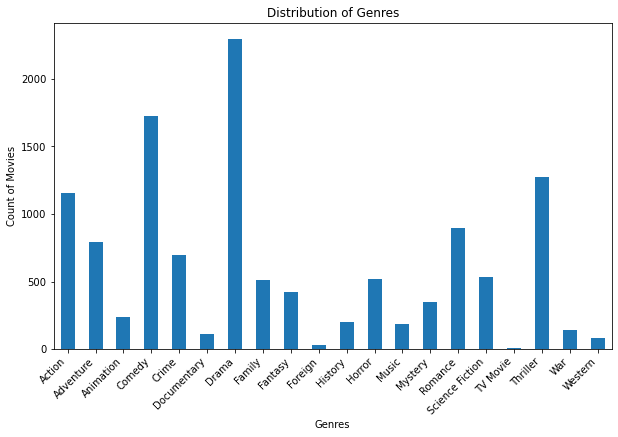

In [390]:
import matplotlib.pyplot as plt

# Assuming 'data_read_labeled' is your DataFrame containing genre columns as well as other columns
# Assuming 'available_genres' is your list of available genres

# Initialize an empty DataFrame to store genre data
genre_data = pd.DataFrame()

# Iterate over the list of available genres
for genre in mlb.classes_:
    # Check if the genre column exists in the DataFrame
    if genre in data_read_labeled.columns:
        # If the genre column exists, add it to the genre_data DataFrame
        genre_data[genre] = data_read_labeled[genre]

# Calculate the count of movies belonging to each genre
genre_counts = genre_data.sum()

# Plot the distribution of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Count of Movies')
plt.title('Distribution of Genres')
plt.xticks(rotation=45, ha='right')
plt.show()


['original_language_af', 'original_language_ar', 'original_language_cn', 'original_language_cs', 'original_language_da', 'original_language_de', 'original_language_el', 'original_language_en', 'original_language_es', 'original_language_et', 'original_language_fa', 'original_language_fr', 'original_language_he', 'original_language_hi', 'original_language_hu', 'original_language_id', 'original_language_is', 'original_language_it', 'original_language_ja', 'original_language_ko', 'original_language_ky', 'original_language_nb', 'original_language_nl', 'original_language_no', 'original_language_pl', 'original_language_ps', 'original_language_pt', 'original_language_ro', 'original_language_ru', 'original_language_sl', 'original_language_sv', 'original_language_ta', 'original_language_te', 'original_language_th', 'original_language_tr', 'original_language_vi', 'original_language_xx', 'original_language_zh']


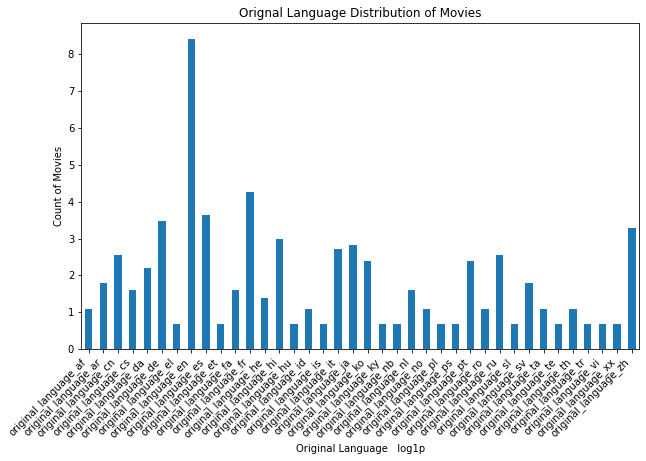

In [391]:
import matplotlib.pyplot as plt

# Assuming 'data_read_labeled' is your DataFrame containing genre columns as well as other columns
# Assuming 'available_genres' is your list of available genres

# Initialize an empty DataFrame to store genre data
genre_data = pd.DataFrame()

original_columns = ['original_language_af', 'original_language_ar', 'original_language_cn',
       'original_language_cs', 'original_language_da', 'original_language_de',
       'original_language_el', 'original_language_en', 'original_language_es',
       'original_language_et', 'original_language_fa', 'original_language_fr',
       'original_language_he', 'original_language_hi', 'original_language_hu',
       'original_language_id', 'original_language_is', 'original_language_it',
       'original_language_ja', 'original_language_ko', 'original_language_ky',
       'original_language_nb', 'original_language_nl', 'original_language_no',
       'original_language_pl', 'original_language_ps', 'original_language_pt',
       'original_language_ro', 'original_language_ru', 'original_language_sl',
       'original_language_sv', 'original_language_ta', 'original_language_te',
       'original_language_th', 'original_language_tr', 'original_language_vi',
       'original_language_xx', 'original_language_zh']
print(original_columns)

# Iterate over the list of available genres
for genre in original_columns:
    # Check if the genre column exists in the DataFrame
    if genre in data_read_labeled.columns:
        # If the genre column exists, add it to the genre_data DataFrame
        genre_data[genre] = data_read_labeled[genre]

# Calculate the count of movies belonging to each genre
genre_counts = genre_data.sum()
genre_counts = np.log1p(genre_counts)


# Plot the distribution of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Original Language   log1p')
plt.ylabel('Count of Movies')
plt.title('Orignal Language Distribution of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()


In [392]:

# Define the desired range
data_read_labeled['release'] = data_read_labeled['release'].astype('int64') / 10**9
desired_min = 0
desired_max = 6000
data_copy = data_read_labeled.copy()

# Assuming 'df' is your DataFrame with numerical features
# Initialize MinMaxScaler with the desired range
numerical_features = data_copy.select_dtypes(include=['float64', 'int64'])

scaler = MinMaxScaler(feature_range=(desired_min, desired_max))

# Fit and transform the data
scaled_features = scaler.fit_transform(numerical_features)

# Convert the scaled features back to a DataFrame (if needed)
scaled_numerical_df = pd.DataFrame(scaled_features, columns=numerical_features.columns)
scaled_df = pd.concat([data_copy.drop(columns=numerical_features.columns), scaled_numerical_df], axis=1)
scaled_df.head()


C:\Users\edoua\AppData\Local\Temp/ipykernel_6396/590392689.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data_read_labeled['release'] = data_read_labeled['release'].astype('int64') / 10**9


,original_language_af,original_language_ar,original_language_cn,original_language_cs,original_language_da,original_language_de,original_language_el,original_language_en,original_language_es,original_language_et,...,War,Western,vote_count,vote_average,spoken_languages,duration,revenue,release,popularity,financial_investment
0,0,0,0,0,0,0,0,1,0,0,...,0,0,5148.342059,4320.0,750.0,2875.739645,6000.000000,5290.965571,1030.887088,3742.105263
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1963.350785,4140.0,0.0,3000.000000,2068.175110,5145.586332,953.076185,4736.842105
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1948.516579,3780.0,3000.0,2627.218935,1895.306250,5624.281646,735.809141,3868.421053
3,0,0,0,0,0,0,0,1,0,0,...,0,0,3972.949389,4560.0,0.0,2928.994083,2334.905349,5438.363966,769.634637,3947.368421
4,0,0,0,0,0,0,0,1,0,0,...,0,0,926.701571,3660.0,0.0,2343.195266,611.497830,5418.017085,301.013702,4105.263158


## Models and Training
### Dataset Split

Once all the previous data manipulation making our dataset usable we divided it in three different datasets to use:

- 70% for training
- 15% for validation
- 15% for test

In [393]:
from sklearn.model_selection import train_test_split

X = scaled_df.drop(columns=['revenue']) 
y = scaled_df['revenue']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of each split
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 3362
Validation set size: 720
Test set size: 721


### Creating the models and calculating the RMSLE
We decided to test 6 different models to see their performance and be able to pick out the best one for use for our final model:

- Multi-Layer Perceptron (MLP)
- Linear Regression
- Decision Tree
- Random Forest 
- XGBoost
- K-Nearest Neighbors (Knn)

In the cell below we created each model in a dictionary to be able to use them. 
We then also instanciated a rmsle(Root Mean Squared Log Error) function to be able to calculate the relative error between the predicted and the actual values, we used this method to evaluate our models. As it will give us a good idea of the ratio (instead of the difference with RMSE) between the predicted values coming from our model and the target values we're looking for.  

In [394]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
import numpy as np

def rmsle(y_true, y_pred):

    y_pred = np.clip(y_pred, 1e-9, None)
    # Compute RMSLE
    rmsle_value = np.sqrt(np.mean(np.square(np.log1p(y_true+1) - np.log1p(y_pred+1))))
    
    errors = np.where(y_true <= 0)[0]
    return rmsle_value




models = {
    'MLP': MLPRegressor(learning_rate='adaptive', max_iter=1000, random_state=42, early_stopping=True, verbose=True),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(n_estimators=100),
    'Knn': KNeighborsRegressor()
}

i=0

for name, model in models.items():
    predictions = []
    model.fit(X_train, y_train,)
    predictions.append(model.predict(X_val))
    rmsle_score = rmsle(y_val, predictions[0])
    print(name, "RMSLE:", rmsle_score)

    
    #print(f"predictions for {name}", predictions)
# # Calculate RMSLE for each model
# rmsle_scores = []
# errorvalues = []
# for i in range(len(predictions)):
#     rmsle_scores.append(rmsle(y_val, predictions))
    

# # Print RMSLE scores
# for i in range(len(models)):
#     

Iteration 1, loss = 76563.58168158
Validation score: 0.267020
Iteration 2, loss = 36144.84390128
Validation score: 0.523632
Iteration 3, loss = 24372.96370983
Validation score: 0.591694
Iteration 4, loss = 20751.13375938
Validation score: 0.614574
Iteration 5, loss = 19854.58579335
Validation score: 0.625960
Iteration 6, loss = 19161.56014461
Validation score: 0.624880
Iteration 7, loss = 18736.11643535
Validation score: 0.634675
Iteration 8, loss = 18473.57930890
Validation score: 0.633423
Iteration 9, loss = 18161.08471048
Validation score: 0.633033
Iteration 10, loss = 17989.11796596
Validation score: 0.635686
Iteration 11, loss = 18114.36144496
Validation score: 0.636296
Iteration 12, loss = 18014.40380781
Validation score: 0.639498
Iteration 13, loss = 17647.28712371
Validation score: 0.627179
Iteration 14, loss = 17547.57240848
Validation score: 0.636703
Iteration 15, loss = 17764.15326893
Validation score: 0.626132
Iteration 16, loss = 17474.32072413
Validation score: 0.603834
I

### Plotting of the Graphs 

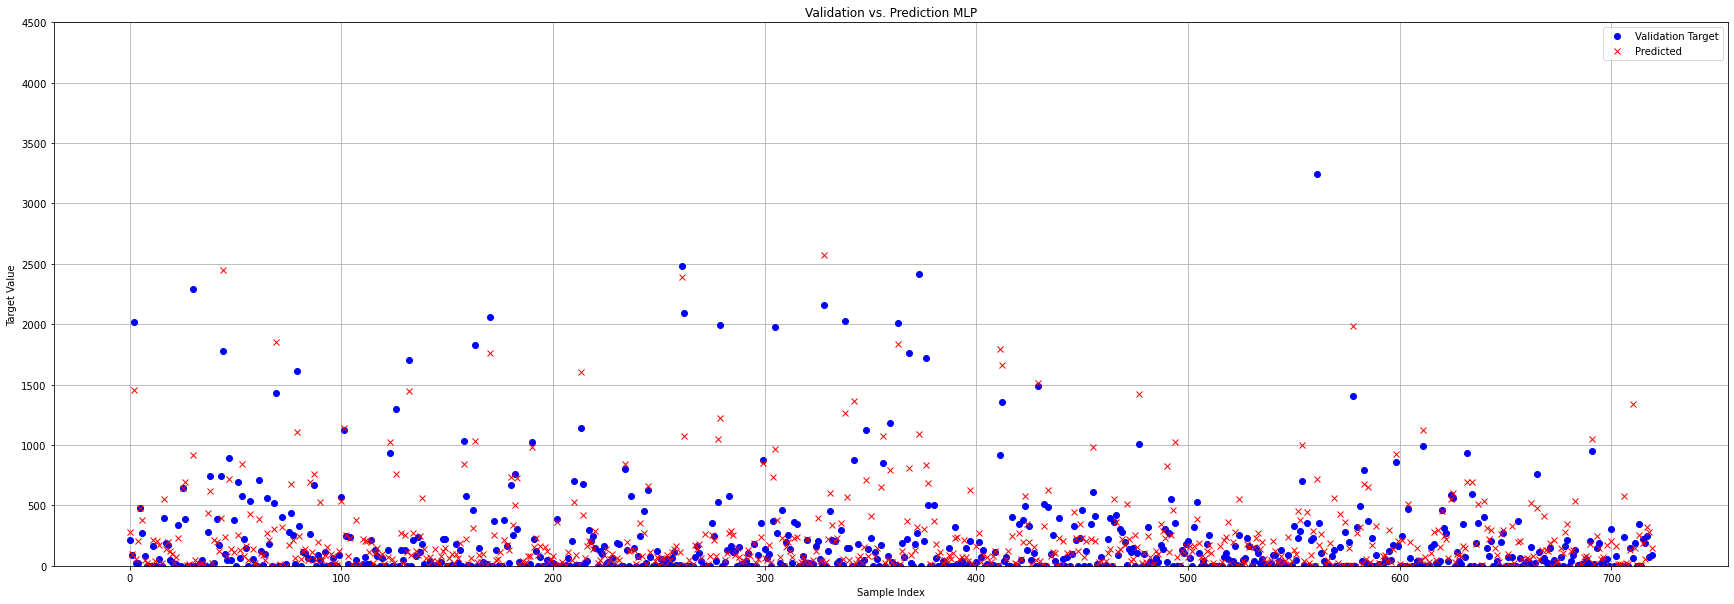

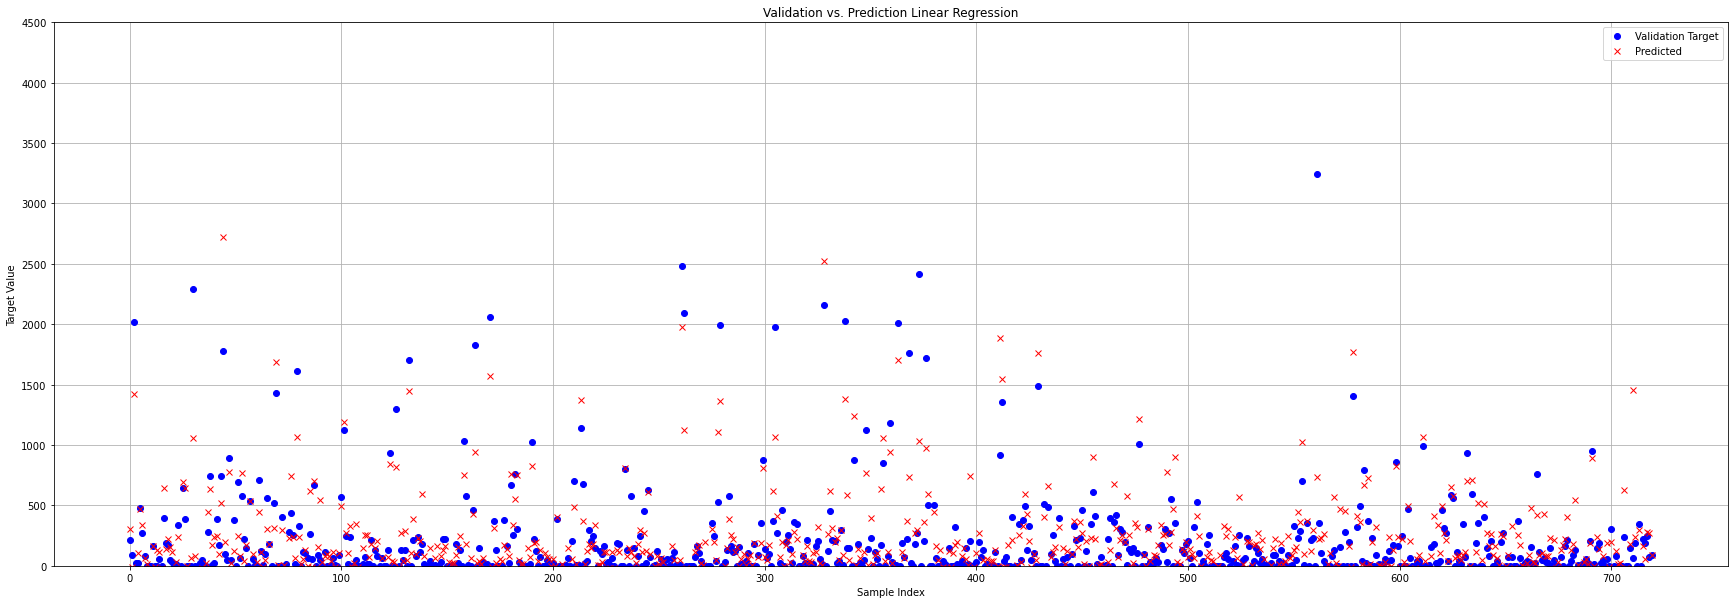

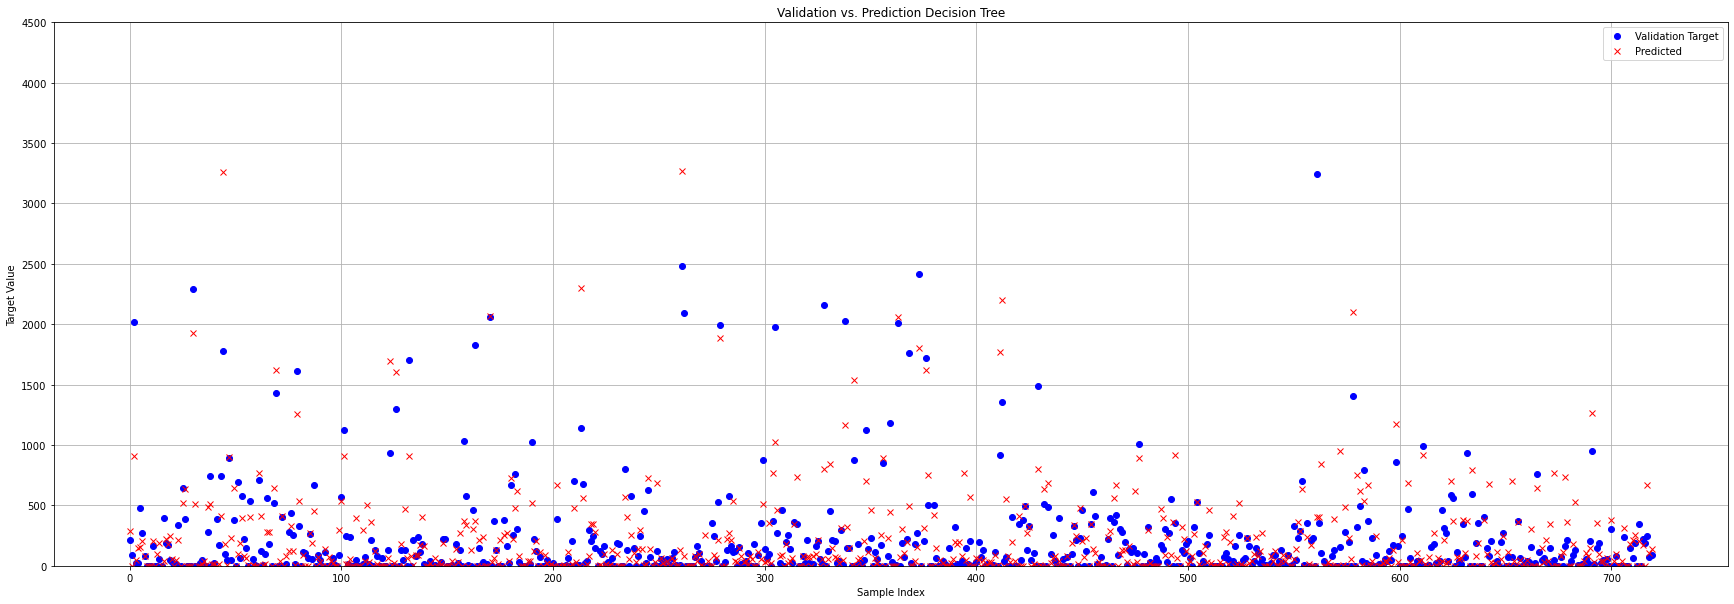

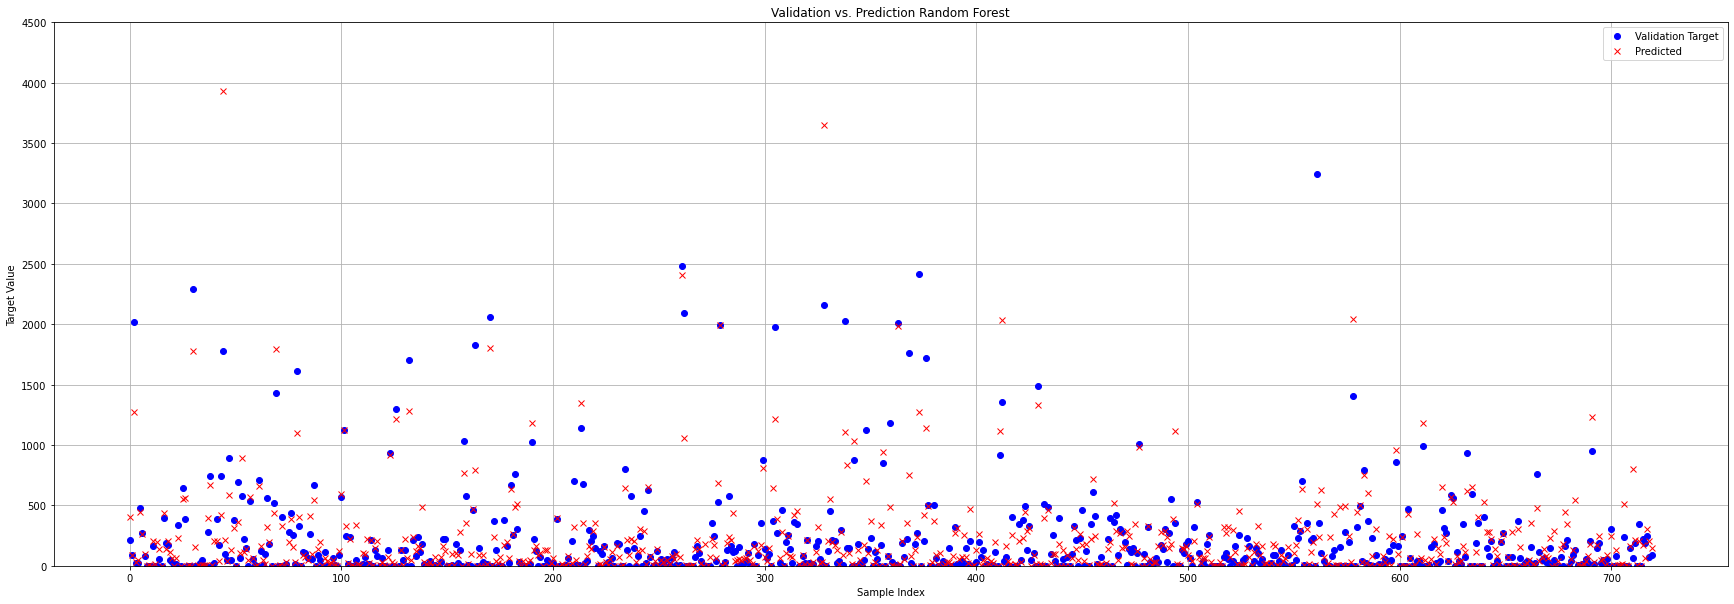

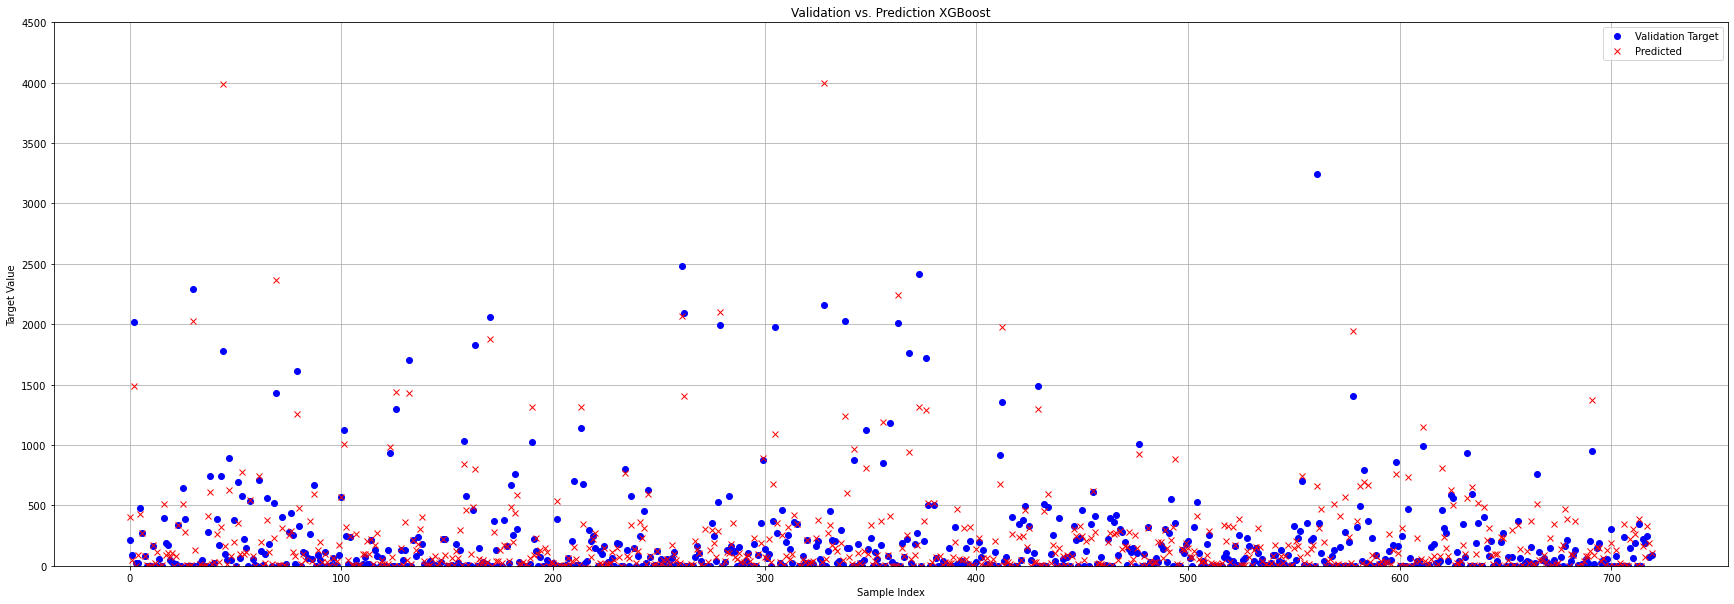

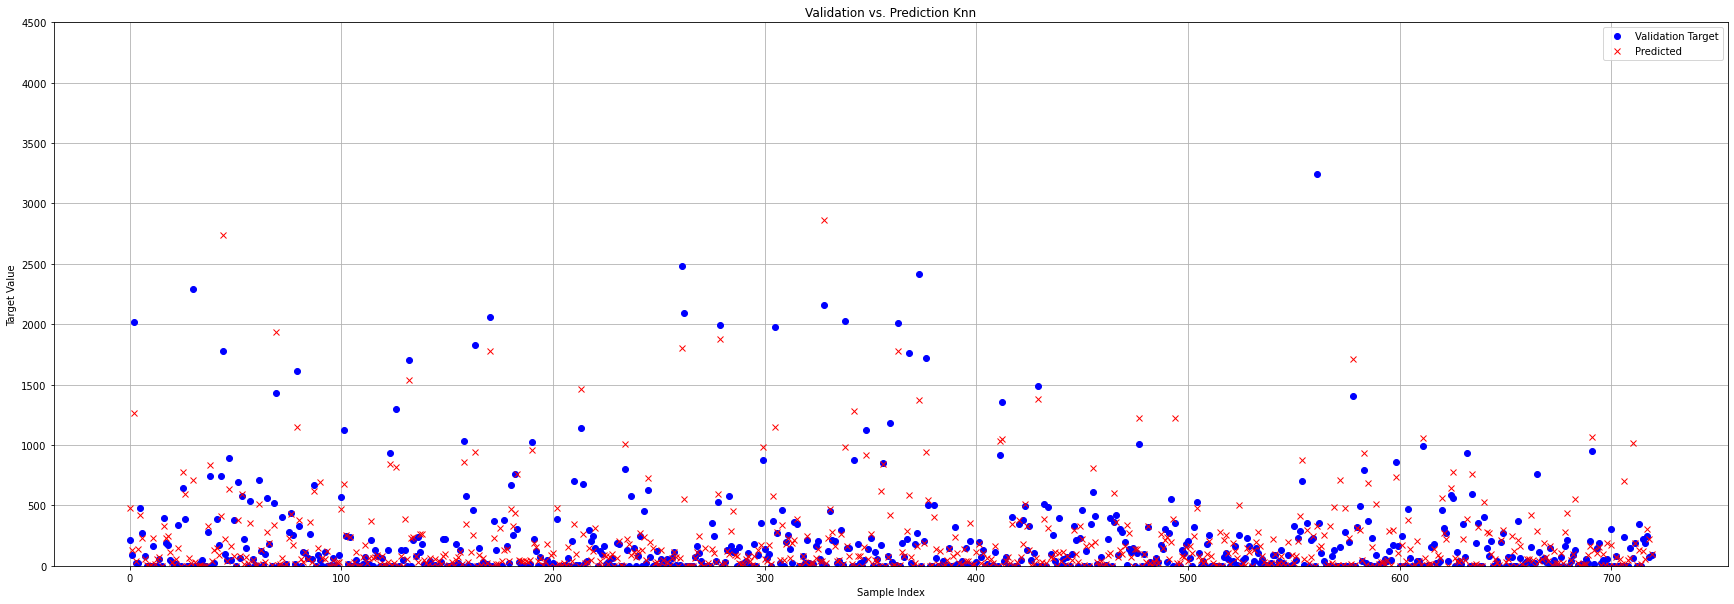

In [395]:
import matplotlib.pyplot as plt


x = [i for i in range(len(y_val))]


for name, model in models.items():
    y_pred = model.predict(X_val)

    plt.figure(figsize=(30, 10))
    plt.plot(y_val.values, label='Validation Target', color='blue', marker='o', linestyle='None')  
    plt.plot(y_pred, label='Predicted', color='red', marker='x', linestyle='None') 
    plt.xlabel('Sample Index')
    plt.ylabel('Target Value')
    plt.title('Validation vs. Prediction ' + name)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 4500) #Added to limit the graph size
    plt.show()


Considering these graphs it is difficult to tell the best performing model but looking at the actual RMSLE scores we can clearly see the Linear regression model is the least performant for our use case. The model that seems the best fitting for us is the Random Forest model closely followed by XGBoost as the lower the value the less the actual ratio difference between the prediction and the validation target. Looking back at the graphs knowing this we can see that on the Random Tree graph, the red dots are in general less far away of the X-axis then the other graphs.

| Model                | RMSLE               |
|----------------------|---------------------|
| MLP                  | 1.5449756093506855  |
| Linear Regression    | 2.6206742895103767  |
| Decision Tree        | 1.6344121272753727  |
| Random Forest        | 1.3122444426033288  |
| XGBoost              | 1.3837133161884367  |
| KNN                  | 1.4493320917953147  |

## Cross Validation 
To be able to further tell the performance of each model we are going to perform some cross-validation, where the dataset will be divided into multiple subsets. In our case we are cross validating with a factor of 5 and we are using the RMSLE as a scoring factor to tell which has the lowest value. 

In [396]:
from sklearn.model_selection import cross_val_score

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

for name, model in models.items():
    scores = np.abs(cross_val_score(model, X_val, y_val, cv=5, scoring=rmsle_scorer))
    print(f"Model: {name}")
    print(f"Cross-validated scores: {scores}")
    print(f"Mean score: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")
    print() 




Iteration 1, loss = 144464.98660624
Validation score: -0.333682
Iteration 2, loss = 75268.94589998
Validation score: 0.016246
Iteration 3, loss = 71602.04592111
Validation score: 0.092502
Iteration 4, loss = 73792.67711553
Validation score: 0.176634
Iteration 5, loss = 61017.35239433
Validation score: 0.241455
Iteration 6, loss = 47672.90195355
Validation score: 0.239932
Iteration 7, loss = 43202.71247341
Validation score: 0.230217
Iteration 8, loss = 41644.92521236
Validation score: 0.297036
Iteration 9, loss = 36354.64363295
Validation score: 0.414682
Iteration 10, loss = 31445.19967112
Validation score: 0.523494
Iteration 11, loss = 28183.86224610
Validation score: 0.585907
Iteration 12, loss = 27045.24965973
Validation score: 0.620633
Iteration 13, loss = 25367.20013043
Validation score: 0.636172
Iteration 14, loss = 23583.86097890
Validation score: 0.632921
Iteration 15, loss = 23119.74522686
Validation score: 0.638649
Iteration 16, loss = 22845.77065100
Validation score: 0.667499

We can again look at the different values and see that Random Forest Model has the lowest values and thus is the best performing.

| Model             | Cross-validated scores                      | Mean score       | Standard deviation |
|-------------------|---------------------------------------------|------------------|--------------------|
| MLP               | [1.47637783, 1.68886155, 1.52542855, 1.66553396, 1.29114319] | 1.5294690137267462 | 0.1439123690625895 |
| Linear Regression | [1.50827875, 1.784302, 1.75408152, 1.73102222, 1.40016143]    | 1.6355691841797253 | 0.15290361239773634 |
| Decision Tree     | [1.73135751, 1.75955203, 1.58530097, 1.58167968, 1.5647605]  | 1.644530137609212  | 0.08317511260202815 |
| Random Forest     | [1.38078797, 1.46635262, 1.34112133, 1.49812322, 1.16432442] | 1.3701419115103204 | 0.11743260913885346 |
| XGBoost           | [1.46798821, 1.51341297, 1.45441962, 1.61004528, 1.32431058] | 1.4740353314403174 | 0.09261549360340557 |
| Knn               | [1.60803182, 1.82466104, 1.52906541, 1.8072061, 1.48453573]  | 1.6507000198689012 | 0.14070018655714375 |


#### Parameter Fine-tuning

Now we are going to play with the different parameters to be able to have the best model, in our case we are going to play with the parameter n_estimator. To be able to again calculate the RSMLE and plot it on a graph for each model so that we can take our final decision.

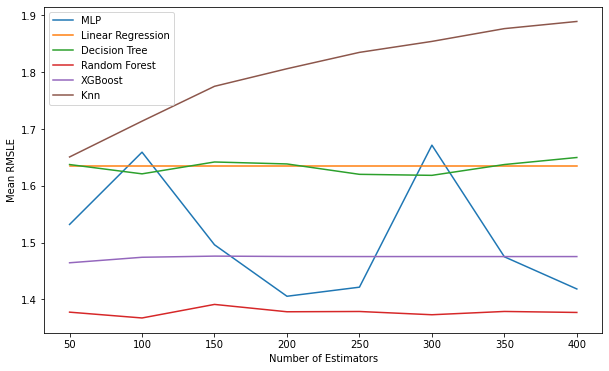

In [397]:
def get_score(n_estimators):
    results = {}
    for name, model in models.items():
        if name in ['Random Forest', 'XGBoost']:
            model.set_params(n_estimators=n_estimators)
        elif name == 'Knn':
            model.set_params(n_neighbors=n_estimators//10)
        elif name == 'MLP':
            model.set_params(verbose=False, hidden_layer_sizes=(n_estimators, n_estimators//2))
        scores = np.abs(cross_val_score(model, X_val, y_val, cv=5, scoring=rmsle_scorer))
        results[name] = scores.mean()
    return results

estimators_range = range(50, 401, 50)
results = {n: get_score(n) for n in estimators_range}

plt.figure(figsize=(10, 6))
for name in models.keys():
    plt.plot(estimators_range, [results[n][name] for n in estimators_range], label=name)


plt.xlabel('Number of Estimators')
plt.ylabel('Mean RMSLE')
plt.legend()
plt.show()


From this graph we can rank the performance of our different models to be able to decide on the final model to use on our test model. We can see that the best model is the Random Forest algorithm as we previously thought. But we can also see that in some cases (when the estimators are between 200 and 250) that the MLP can be surprisingly good. But now for our final decision we choosed to use the Random Tree model with the hyperparameter of n_estimators set to 200 as we can see on the graph that this has the best RMSLE value .

# Final Model 

Now having seen that the Random Forest model has the best performance of the six models we analyzed, we are going to train a RandomForestRegressor model on the training dataset we defined earlier to then make it do a prediction on the test data set. By also calculating the RMSLE value for this case we will also be able to see the good perfomance of the Random Tree algorithm with the n_estimators hyperparameter set to 200 as we've seen in the hyperparameter part that this was the most optimal setup. To showcase this we tested our final model with n_estimators set to 100 and to 200, and this was the RMSLE value for both setups:
|n_estimators| RMSLE |
|--------|----------|
| 100  | 1.3860862315710283|
| 200 | 1.378561610354363|

Confirming us that we found the best model for our problem that was the prediction of movie prices.



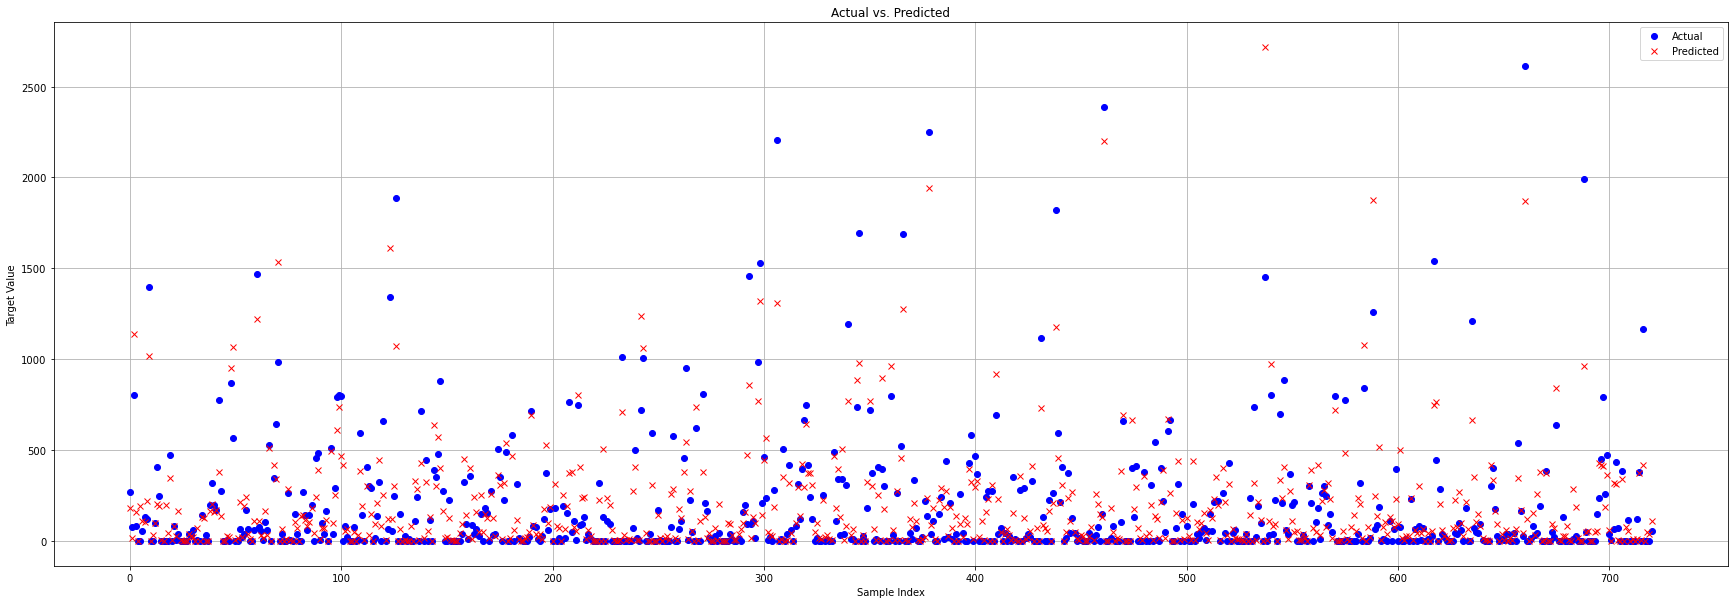

This is the RMSLE value:
1.378561610354363


In [398]:
model_final = RandomForestRegressor(n_estimators = 200)
model_final.fit(X_train, y_train)



y_pred_final = model_final.predict(X_test)
#print(y_pred_final)



plt.figure(figsize=(30, 10))
plt.plot(y_test.values, label='Actual', color='blue', marker='o', linestyle='None')  
plt.plot(y_pred_final, label='Predicted', color='red', marker='x', linestyle='None') 
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()

print('This is the RMSLE value:')
print(rmsle(y_test, y_pred_final))

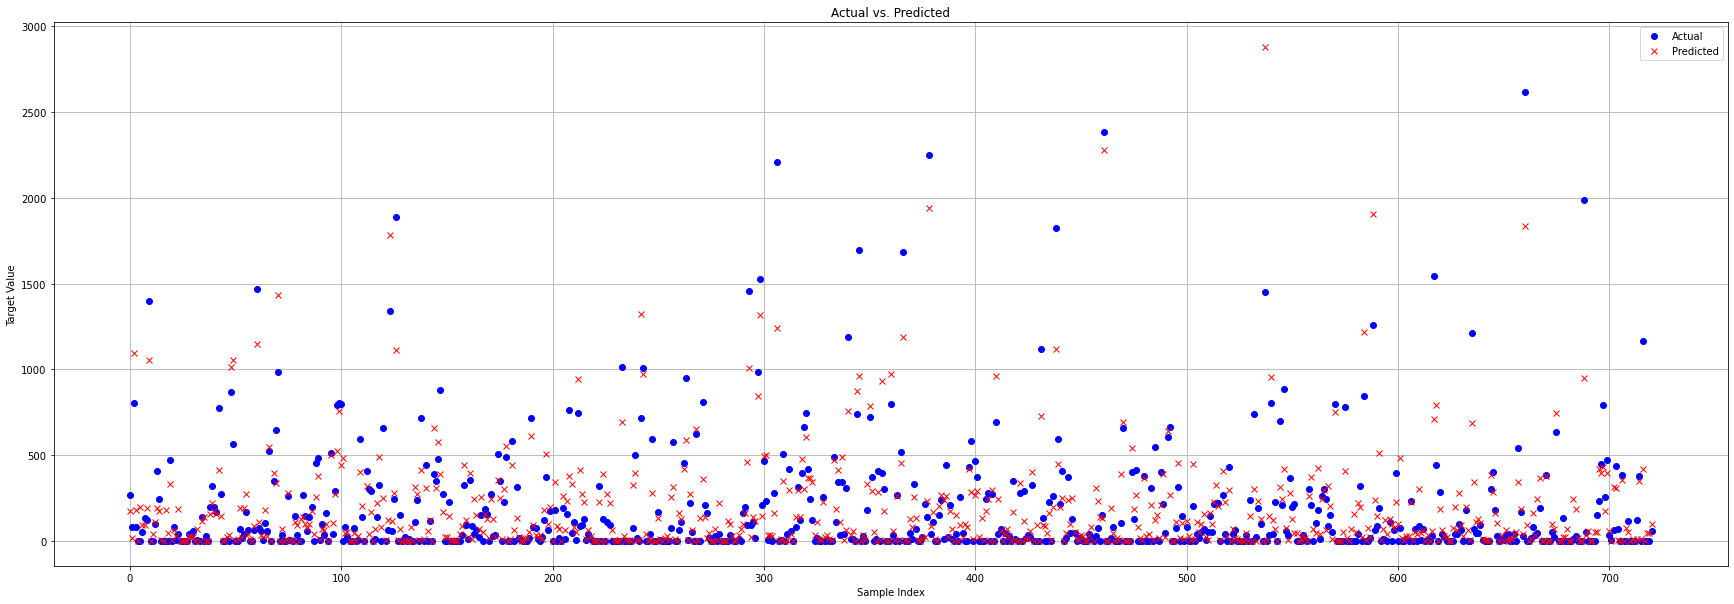

This is the RMSLE value:
1.3860862315710283


In [399]:
model_final = RandomForestRegressor(n_estimators = 100)
model_final.fit(X_train, y_train)



y_pred_final = model_final.predict(X_test)
#print(y_pred_final)



plt.figure(figsize=(30, 10))
plt.plot(y_test.values, label='Actual', color='blue', marker='o', linestyle='None')  
plt.plot(y_pred_final, label='Predicted', color='red', marker='x', linestyle='None') 
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()

print('This is the RMSLE value:')
print(rmsle(y_test, y_pred_final))

# Conclusion
In this notebook we showcased how it is really important to have good data when trying to build a machine learning algorithm. AS this data is the only means by which our machine will think it needs to be correctly encoded and complete. This is why validation of the data and processing it is a really important part to make it easier for the machine to think and to decide in the end.

Once this data is correct you can start choosing the model that you want to use. In this notebook we showed 6 different models that exist tried to evaluate them to be able to make a final choice. This evaluation and interpretation was primarly done through the calculation of the RMSLE metric as it showed to be one of the best ways to get a scientific number/rating of the performance of a model.

